In [5]:
import networkx as nx
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

__Loading Karate Graph__

In [6]:
dataset = KarateClub()[0]

karate_graph: nx.Graph = to_networkx(dataset)

for node in karate_graph.nodes():
    karate_graph.nodes[node]["class"] = dataset.y.tolist()[node]

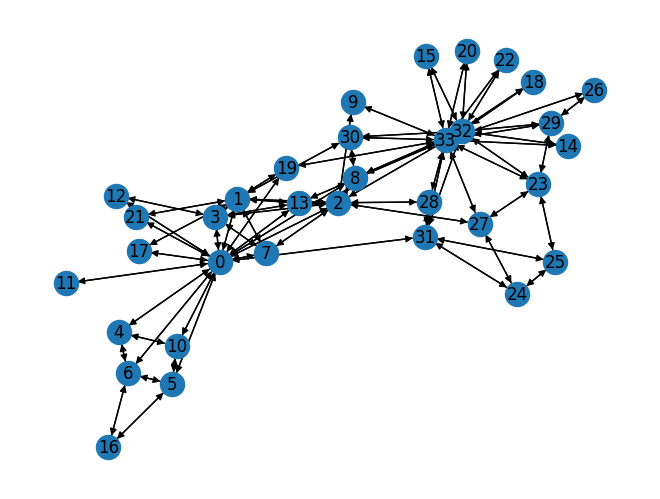

In [7]:
nx.draw(karate_graph, with_labels=True)

__GraRep__

In [ ]:
class GraRep(object):
    def __init__(self, A, args):
        """
        :param A: Adjacency matrix.
        :param args: Arguments object.
        """
        self.A = A
        self.args = args
        self._setup_base_target_matrix()

    def _setup_base_target_matrix(self):
        """
        Creating a base matrix to multiply.
        """
        values = [1.0 for _ in range(self.A.shape[0])]
        indices = [i for i in range(self.A.shape[0])]
        self.A_hat = sparse.coo_matrix((values, (indices, indices)),
                                       shape=self.A.shape,
                                       dtype=np.float32)

    def _create_target_matrix(self):
        """
        Creating a log transformed target matrix.
        :return target_matrix: Matrix to decompose with SVD.
        """
        self.A_hat = sparse.coo_matrix(self.A_hat.dot(self.A))
        scores = np.log(self.A_hat.data)-math.log(self.A.shape[0])
        rows = self.A_hat.row[scores < 0]
        cols = self.A_hat.col[scores < 0]
        scores = scores[scores < 0]
        target_matrix = sparse.coo_matrix((scores, (rows, cols)),
                                          shape=self.A.shape,
                                          dtype=np.float32)
        return target_matrix

    def optimize(self):
        """
        Learning an embedding.
        """
        print("\nOptimization started.\n")
        self.embeddings = []
        for step in tqdm(range(self.args["order"])):
            target_matrix = self._create_target_matrix()

            svd = TruncatedSVD(n_components=self.args["dim"],
                               n_iter=self.args["iter"],
                               random_state=self.args["seed"])

            svd.fit(target_matrix)
            embedding = svd.transform(target_matrix)
            self.embeddings.append(embedding)

    def return_embedding(self):
        """
        Return the embedding.
        """
        print("\nReturn embedding.\n")
        self.embeddings = np.concatenate(self.embeddings, axis=1)
        column_count = self.args["order"] * self.args["dim"]
        columns = ["ID"] + ["x_" + str(col) for col in range(column_count)]
        ids = np.array([i for i in range(self.A.shape[0])]).reshape(-1,1)
        self.embeddings = np.concatenate([ids, self.embeddings], axis=1)
        self.embeddings = pd.DataFrame(self.embeddings, columns=columns)
        
        return self.embeddings

### Assigment 1. Given a karate graph  
Questions :  
   * Calculate the transition matrix, $A^1$, $A^2$, ..., $A^4$

### Assigment 2. Given a karate graph  
Questions :  
   * Calculate the node features based on GraRep and do visualization with TSNE